In [1]:
# instaliranje zahtjeva
!pip install tensorflow
!pip install matplotlib
!pip install numpy

In [2]:
# dodavanje modula
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# definiranje konstanti:
img_height = 256
img_width = 256
batch_size = 64
channels = 3
epochs = 5

In [4]:
# učitavanje skupa podataka slika
import pathlib
data_dir = pathlib.Path(r"C:\Users\marko\vectrino\training\Vectrino")

In [5]:
# provjera 
import os
if os.path.exists(data_dir):
    print("Slike su uspješno preuzete.")
else:
    print("Slike nisu pronađene.")

Slike su uspješno preuzete.


In [6]:
# ukupan broj fotografija koje pripadaju i iznad i ispod mora
image_count = len(list(data_dir.glob('*/*.JPG')))
print("Ukupan broj fotografija: ", image_count)

Ukupan broj fotografija:  9412


In [7]:
df_vectrino = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 9412 files belonging to 2 classes.


In [8]:
class_names = df_vectrino.class_names
print("Nazivi klasa su: ", class_names)

Nazivi klasa su:  ['ispodMora', 'iznadMora']


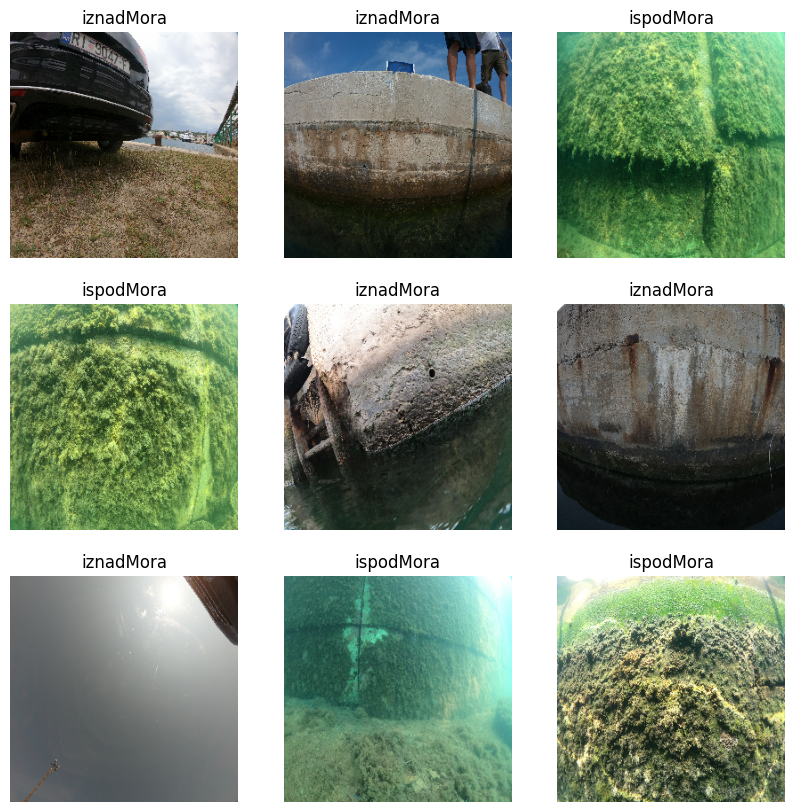

In [9]:
# Prikaz nekoliko fotografija
plt.figure(figsize=(10,10))
for image_batch, label_batch in df_vectrino.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), aspect="auto")
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
# specifikacije treninga:
# 70% skupa za trening
# 30% preostalih se dijeli u 15% za validaciju i 15% za test

train_size = 0.7
num_train_batches = int(len(df_vectrino) * train_size)
print(f"Za trening se koristi {train_size:.2f} skupa podataka, što znači {num_train_batches} grupa.")
val_size = 0.15
num_val_batches = int(len(df_vectrino) * val_size)
print(f"Za validaciju se koristi {val_size:.2f} skupa podataka, što znači {num_val_batches} grupa.")
train_dataset = df_vectrino.take(num_train_batches)
to_be_split = df_vectrino.skip(num_train_batches)
validation_dataset = to_be_split.take(int(len(to_be_split) * 0.5))
test_dataset = to_be_split.skip(int(len(to_be_split) * 0.5))
print(f"Podjela skupa podataka: Trening: {len(train_dataset)}, Validacija: {len(validation_dataset)}, Testiranje: {len(test_dataset)}")

Za trening se koristi 0.70 skupa podataka, što znači 103 grupa.
Za validaciju se koristi 0.15 skupa podataka, što znači 22 grupa.
Podjela skupa podataka: Trening: 103, Validacija: 22, Testiranje: 23


In [11]:
# Funkcija za podjelu skupa podataka slika
def get_dataset_splitting_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_test_ds = ds.skip(train_size)
    val_ds = val_test_ds.take(val_size)
    test_ds = val_test_ds.skip(val_size)

    return train_ds, val_ds, test_ds

# Poziv funkcije za podjelu skupa podataka slika
train_dataset, validation_dataset, test_dataset = get_dataset_splitting_tf(df_vectrino)
print(f"Podjela skupa podataka: Trening: {len(train_dataset)}, Validacija: {len(validation_dataset)}, Testiranje: {len(test_dataset)}")

Podjela skupa podataka: Trening: 103, Validacija: 22, Testiranje: 23


In [12]:
# Optimizacija za brzinu treninga - brže treniranje jer su grupe u RAM-u
# Za skup podataka za trening koristimo memoriranje u međumemoriji
# Jer kada treniramo svoj model, zadržavamo ga u RAM-u
# Predpriprema za bolje performanse ako treniramo na GPU-u

# Skup podataka za trening
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Skup podataka za validaciju
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Skup podataka za testiranje
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
# Primjena lanca predprocesiranja - stvaranje slojeva
# Podrška podacima - primjenjuje filtre na slike, kontrast, transformacije -> generira nove uzorke za trening

# Promjena veličine i skaliranje
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Proširenje podataka
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])

# Primjena lanca proširenja podataka na skup za trening
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# izgradnja modela - Convolutional Neural Network (CNN):

input_shape = (batch_size, img_height, img_width, channels)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# sumarni prikaz modela:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)        

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=validation_dataset,
    verbose=1,
    epochs = epochs,
)

Epoch 1/5


103/103 [==============================] - 313s 2s/step - loss: 0.4233 - accuracy: 0.8063 - val_loss: 0.5691 - val_accuracy: 0.7521
Epoch 2/5
103/103 [==============================] - 133s 1s/step - loss: 0.2037 - accuracy: 0.9270 - val_loss: 0.2393 - val_accuracy: 0.9176
Epoch 3/5
103/103 [==============================] - 130s 1s/step - loss: 0.1175 - accuracy: 0.9555 - val_loss: 0.1200 - val_accuracy: 0.9496
Epoch 4/5
103/103 [==============================] - 130s 1s/step - loss: 0.0965 - accuracy: 0.9628 - val_loss: 0.2225 - val_accuracy: 0.9389
Epoch 5/5
103/103 [==============================] - 130s 1s/step - loss: 0.0810 - accuracy: 0.9706 - val_loss: 0.0849 - val_accuracy: 0.9666


In [17]:
scores = model.evaluate(test_dataset)
scores

23/23 [==============================] - 98s 249ms/step - loss: 0.0890 - accuracy: 0.9586


[0.08903636783361435, 0.9585598111152649]

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

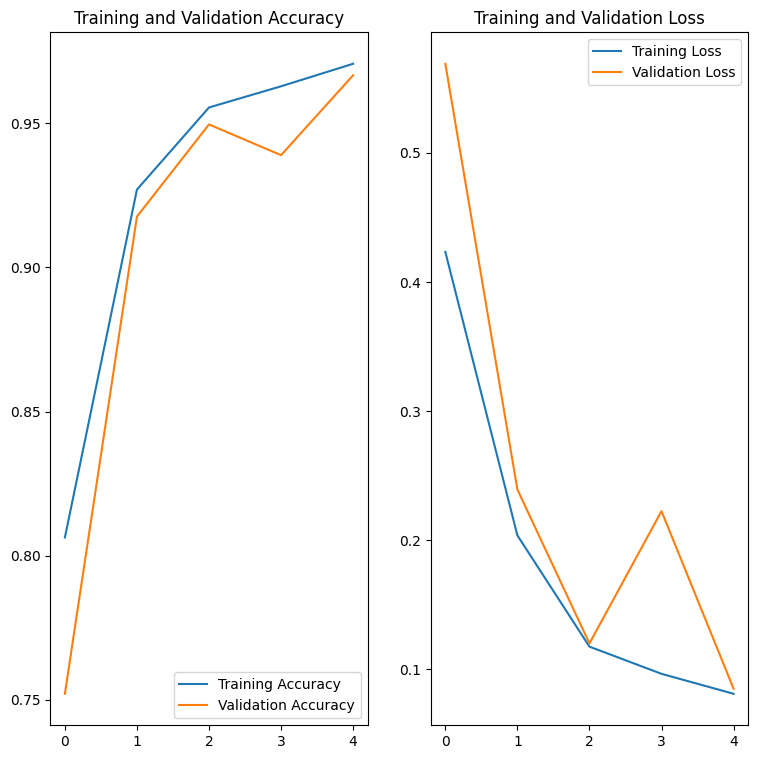

In [19]:
plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Prikaz stvarne i predviđene vrijednosti na jednoj slici iz testnog skupa
Stvarna vrijednost: ispodMora
2/2 [==============================] - 0s 132ms/step
Predviđena vrijednost: ispodMora


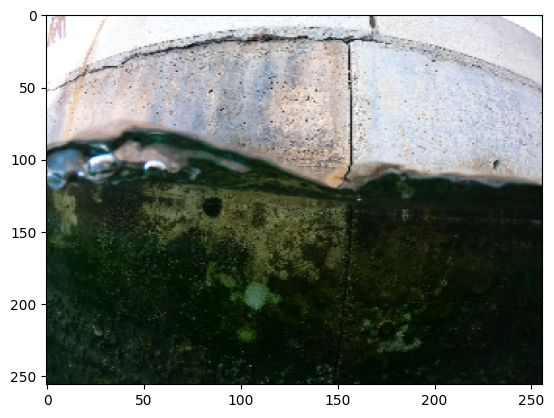

In [20]:
# Predviđanje jedne slike
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("Prikaz stvarne i predviđene vrijednosti na jednoj slici iz testnog skupa")
    plt.imshow(first_image, aspect="auto")
    print("Stvarna vrijednost:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predviđena vrijednost:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 16ms/step


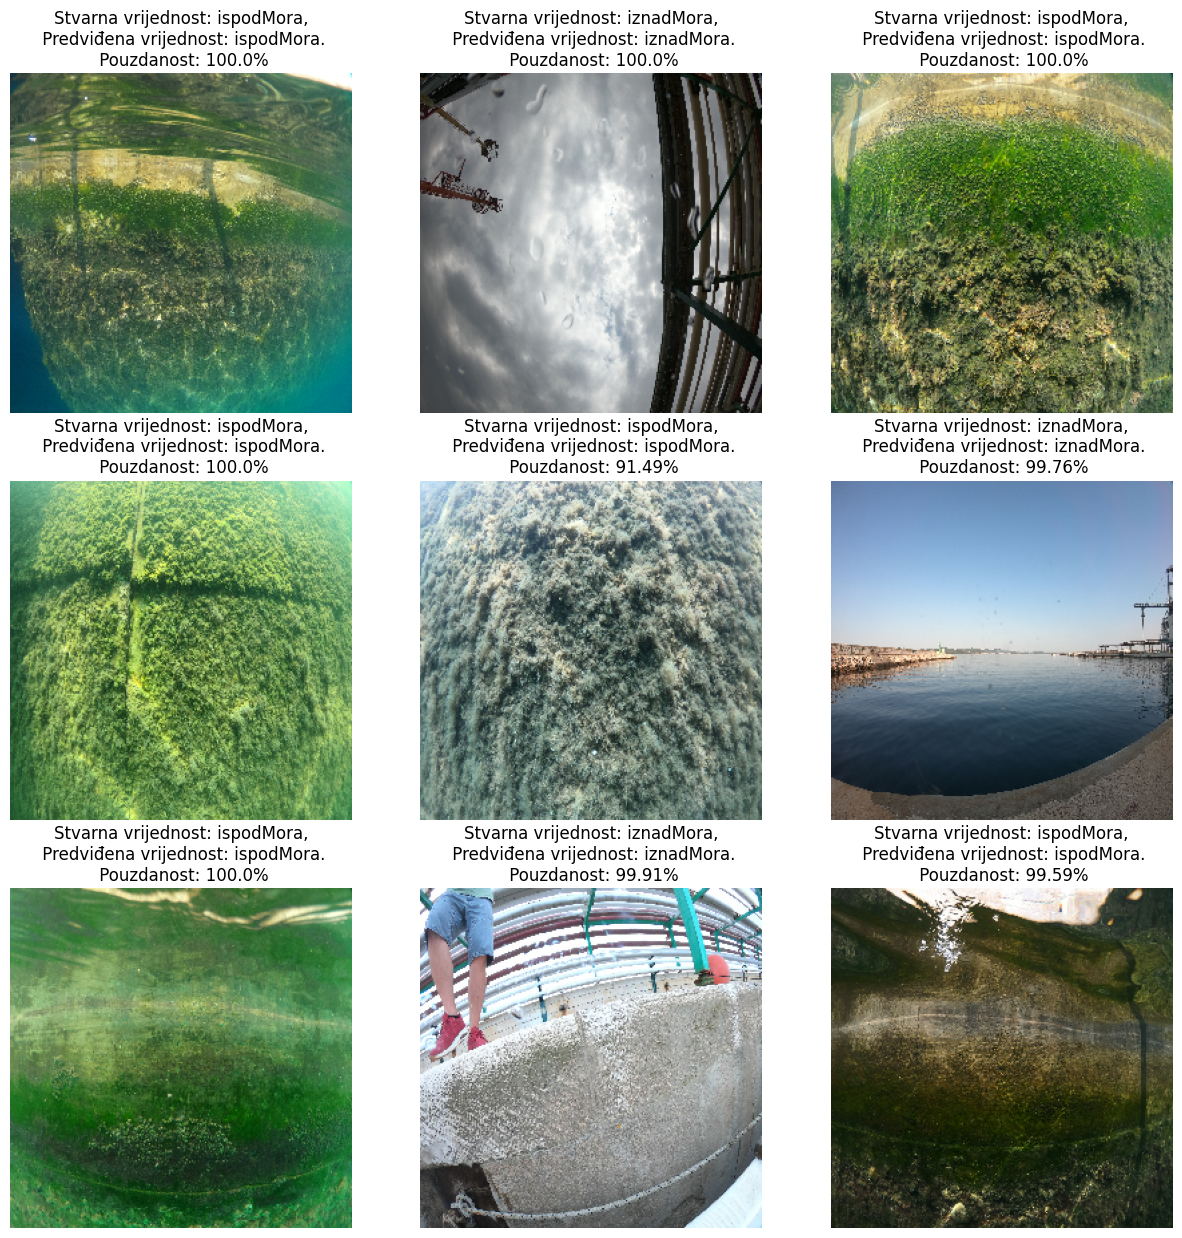

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), aspect="auto")

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Stvarna vrijednost: {actual_class},\n Predviđena vrijednost: {predicted_class}.\n Pouzdanost: {confidence}%")

        plt.axis("off")

In [28]:
import os

model_version = max([int(i) for i in os.listdir(f"C:/Users/marko/vectrino/saved_models") + [0]]) + 1
model.save(f"C:/Users/marko/vectrino/saved_models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/marko/vectrino/saved_models/2\assets


INFO:tensorflow:Assets written to: C:/Users/marko/vectrino/saved_models/2\assets
